# Protein mobility analysis

In [39]:
%cd ..

/home/dkannan/git-remotes


In [38]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
#from tqdm.notebook import tqdm
import seaborn as sns
import sys
from numba import jit
sys.path.insert(0, '/home/dkannan/git-remotes/polychrom_analysis/post_processing')
import msd

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

In [40]:
%matplotlib inline

In [41]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%autoreload 2

In [43]:
slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 0.5,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'axes.titlesize': 20,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'xtick.labelsize': 16,
                  'ytick.labelsize': 16,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.size': 14,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(pres_params)

In [72]:
simdir = Path('/net/levsha/share/deepti/simulations/protein_mobility')

## Ensemble averaged MSDs

### Param sweep 10/30/2023
Ran 18 simulations with 6 values of $E_0 = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]$ and 3 values of the valency $f = [1, 2, 3]$. Plot MSDs for all simulations.

In [7]:
#TODO: write these params to file somehow, same with params (dont just read from folder title doy)
nblocks = 20000
blocksize = 2000

path_dfs = []
for path in simdir.iterdir():
    if path.is_dir():
        params = str(path.name).split('_')
        N = int(params[0][1:])
        f = int(params[1][1:])
        E0 = float(params[2][2:])
        vol_fraction = float(params[3][1:])
        df_row = {'N' : N, 'f' : f, 'E0' : E0, 'v' : vol_fraction, 'path' : path}
        path_dfs.append(df_row)
        if not (path/'sphere_msds_start5000_every_other_10.csv').is_file():
            print(f"Computing MSD for {path.name}")
            molecule_inds = np.arange(0, (f+1)*N, f+1).astype(int)
            molecule_mask = np.bincount(molecule_inds, minlength=N)
            df = pd.DataFrame(columns=['Time', 'MSD'])
            if f < 4:
                #time step for these simulations was 100
                df['Time'] = np.arange(5000, nblocks, 10) - 5000
                msd_all = msd.compute_single_trajectory_msd(path, start=5000, every_other=10, N=N*(f+1))
            else:
                #for f >= 4 changed time step to 70 instead of 100 -- so multiply times by (100/70) to get the same trajectory length
                df['Time'] = np.arange(7142, 28571, 10) - 7142
                msd_all = msd.compute_single_trajectory_msd(path, start=7142, every_other=10, N=N*(f+1))
            #just want sphere MSDs, not that of patches!
            sphere_msds = msd_all[:, molecule_inds].mean(axis=1)
            df['MSD'] = sphere_msds
            df.to_csv(path/'sphere_msds_start5000_every_other_10.csv', index=False)
        
path_df = pd.DataFrame(path_dfs)        

Computing MSD for N1000_f1_E00.1_v0.3_r0.25
1
/net/levsha/share/deepti/simulations/protein_mobility/N1000_f1_E00.1_v0.3_r0.25
[0. 0. 0. ... 0. 0. 0.]
Computing MSD for N1000_f1_E07.0_v0.3_r0.25
1
/net/levsha/share/deepti/simulations/protein_mobility/N1000_f1_E07.0_v0.3_r0.25
[0. 0. 0. ... 0. 0. 0.]
Computing MSD for N1000_f1_E06.0_v0.3_r0.25
1
/net/levsha/share/deepti/simulations/protein_mobility/N1000_f1_E06.0_v0.3_r0.25
[0. 0. 0. ... 0. 0. 0.]
Computing MSD for N1000_f1_E04.0_v0.3_r0.25
1


KeyboardInterrupt: 

## Tabulate all simulation data we have so far

Store parameter values and path to simulation directory in a pandas data frame.

In [44]:
path_dfs = []
for path in simdir.iterdir():
    if path.is_dir():
        params = str(path.name).split('_')
        N = int(params[0][1:])
        f = int(params[1][1:])
        E0 = float(params[2][2:])
        vol_fraction = float(params[3][1:])
        if len(params) > 4:
            r = float(params[4][1:])
        else:
            r = 0.5
        df_row = {'N' : N, 'f' : f, 'E0' : E0, 'v' : vol_fraction, 
                  'r' : r, 'path' : path}
        path_dfs.append(df_row)
path_df = pd.DataFrame(path_dfs)

In [46]:
path_df

,N,f,E0,v,r,path
0,1000,5,0.1,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
1,1000,2,2.5,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
2,1000,3,7.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
3,1000,5,6.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
4,1000,1,3.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
...,...,...,...,...,...,...
71,1000,3,4.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
72,1000,2,0.3,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
73,1000,1,3.0,0.3,0.25,/net/levsha/share/deepti/simulations/protein_m...
74,1000,2,1.5,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...


## Try reducing the interaction radius of patch-patch attraction

For f=1, $E_0 \in [0.0, 7.0]$, did not see a change in mobility with patch attraction radius of $r=0.25$ as you increase $E_0$.

Text(0.5, 1.0, 'MSD, f=1, patch_attr_rad=0.25')

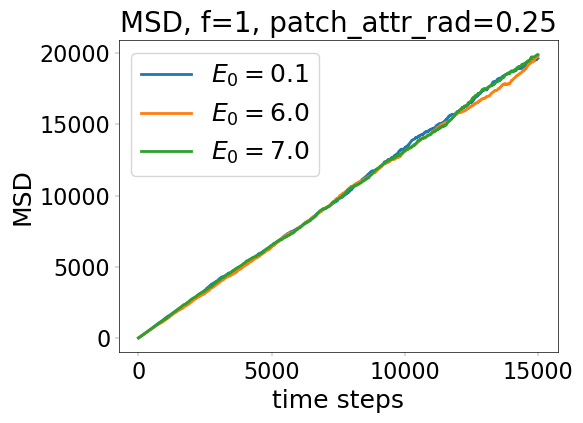

In [10]:
fig, ax = plt.subplots()
for E0 in [0.1, 6.0, 7.0]:
    path = simdir/f"N1000_f1_E0{E0}_v0.3_r0.25"
    msd_df = pd.read_csv(path/'time_ave_msd_every_other_10.csv')
    ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        label=f"$E_0={E0}$")
ax.set_xlabel("time steps")
ax.set_ylabel("MSD")
ax.legend()
ax.set_title("MSD, f=1, patch_attr_rad=0.25")

11/21/23: Ran simulations with higher $E_0$ for f=1 and f=2. Also ran $E_0=0$ and $f=0$ cases for reference.

In [102]:
def plot_time_ave_msd(f, r=0.25):
    fig, ax = plt.subplots()
    E0s = [float(str(path.name).split('_')[2][2:]) for path in simdir.glob(f"N1000_f{f}*_r{r}")]
    colors = sns.color_palette("viridis", len(E0s))
    for i, E0 in enumerate(np.sort(E0s)):
        path = simdir/f"N1000_f{f}_E0{E0}_v0.3_r{r}"
        msdfile = path/'time_ave_msd_every_other_10_start5000.csv'
        if msdfile.is_file():
            msd_df = pd.read_csv(path/'time_ave_msd_every_other_10_start5000.csv')
            ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                            label=f"$E_0={E0}$", color=colors[i])
    ax.set_xlabel("time steps")
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_ylabel("MSD")
    # Put a legend to the right of the current axis
    ax.legend(loc=(1.04, 0.05))
    ax.set_title(f"MSD, f={f}, patch_attr_rad={r}")

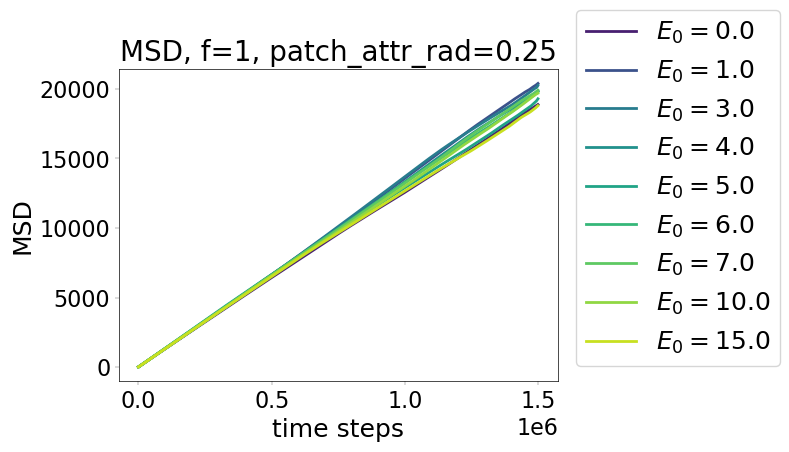

In [104]:
f=1
r=0.25
plot_time_ave_msd(1)

In [71]:
print(simdir)

/net/levsha/share/deepti/simulations/protein_mobility/results


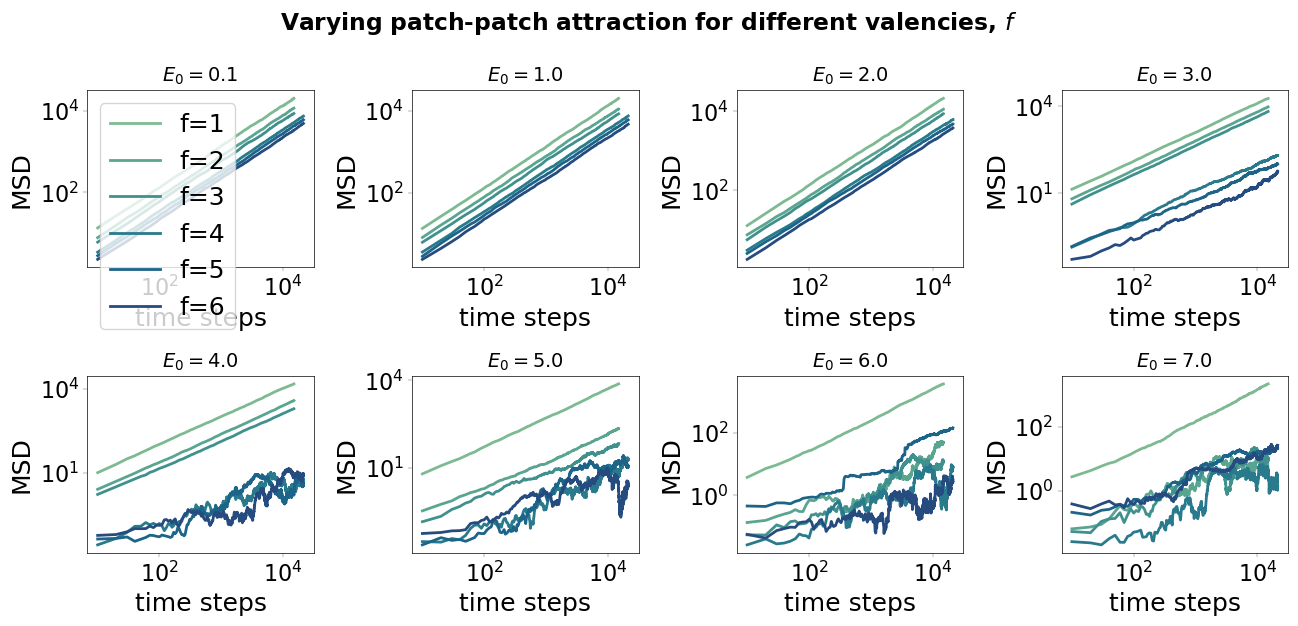

In [16]:
num_rows = 2
num_cols = 4
fig = plt.figure(figsize=(3*1.1*num_cols, 2 + 2*1.1*num_rows))
gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

i=0
E0s = [0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
for E0, mat in path_df.groupby('E0'):
    mat = mat[mat["r"] == 0.5]
    if E0 in E0s:
        df = mat.sort_values('f')
        valencies = df['f'].values
        colors = sns.color_palette("crest", len(valencies))
        paths = df['path'].values

        #plot MSD
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        for j, path in enumerate(paths):
            msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
            if msd_df['Time'].values[0] != 0.0:
                ax.plot(msd_df['Time'].values[1:] - msd_df['Time'].values[0], msd_df['MSD'].values[1:], 
                        color=colors[j], label=f"f={valencies[j]}")
            else:
                ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        color=colors[j], label=f"f={valencies[j]}")
        ax.set_xlabel('time steps')
        ax.set_ylabel('MSD')
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 0:
            ax.legend()
        ax.set_title(f"$E_0={E0}$", fontsize=14)
        i += 1

fig.suptitle(r"Varying patch-patch attraction for different valencies, $f$", fontweight='bold')
fig.tight_layout()
plt.savefig('plots/MSD_varyingE0_f1-6.pdf')

## Time lag averaging for better stats

Curves are noisy even after computing single trajectory MSD averaged over 1000 particles. 
Add time lag averaging for smoother curves.

In [39]:
def extract_particle_trajectory(f, E0, N=1000, v=0.3, start=5000, every_other=10,
                               simdir=Path('results')):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir
    and store particle positions over time in a matrix X.

    Parameters
    ----------
    f : int
        valency
    E0 : float
        patch-patch attraction energy
    simdir : str or Path
        path to parent directory containing simulation folders named "N{N}_f{f}_E0{E0}_v{v}"
    start : int
        which time block to start loading conformations from
    every_other : int
        skip every_other time steps when loading conformations

    Returns
    -------
    X : array_like (num_t, num_particles, 3)
        x, y, z positions of all particles (excluding patches) over time

    """
    simdir = simdir/f"N{N}_f{f}_E0{E0}_v{v}"
    molecule_inds = np.arange(0, (f+1)*N, f+1).astype(int)
    totalN = (f + 1) * N
    X = []
    data = list_URIs(simdir)
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir) / "starting_conformation_0.h5")[
            "pos"
        ]
        X.append(starting_pos)
    for conformation in data[start::every_other]:
        pos = load_URI(conformation)["pos"]
        ncopies = pos.shape[0] // totalN
        for i in range(ncopies):
            posN = pos[totalN * i : totalN * (i + 1)]
            X.append(posN)
    X = np.array(X)
    Xparticle = X[:, molecule_inds, :]
    return Xparticle


@jit(nopython=True)
def get_bead_msd_time_ave(X):
    """Calculate time lag averaged MSDs of particles in a single simulation trajectory stored in X.

    Parameters
    ----------
    X : np.ndarray (num_t, num_particles, d)
        trajectory of particle positions in d dimensions over num_t timepoints
        
    Returns
    -------
    msd_ave : (num_t - 1,)
        time lag averaged MSD averaged over all particles

    """
    num_t, num_particles, d = X.shape
    msd = np.zeros((num_t - 1,))
    count = np.zeros((num_t - 1,))
    for i in range(num_t - 1):
        for j in range(i, num_t - 1):
            diff = X[j] - X[i]
            msd[j - i] += np.mean(np.sum(diff * diff, axis=-1))
            count[j - i] += 1
    msd_ave = msd / count
    return msd_ave

In [28]:
%%time
X = extract_particle_trajectory(4, 4.0)

(2143, 5000, 3)
(2143, 1000, 3)
CPU times: user 3.02 s, sys: 189 ms, total: 3.21 s
Wall time: 3.22 s


In [29]:
%%time
msd = get_bead_msd_time_ave(X)

CPU times: user 46.5 s, sys: 320 ms, total: 46.8 s
Wall time: 1min 3s


In [31]:
msd.shape

(2142,)

In [37]:
def save_time_ave_msd(f, E0, every_other=10):
    if f < 4:
        start = 5000
        time_per_step = 100
    else:
        start = 7142
        time_per_step = 70
    X = extract_particle_trajectory(f, E0, start=start, every_other=10)
    msd = get_bead_msd_time_ave(X)
    df = pd.DataFrame()
    #in units of femtoseconds (arbirtary unit used by openMM)
    df['Time'] = np.arange(0, len(msd)) * every_other * time_per_step
    df['MSD'] = msd
    path = Path(f"results/N1000_f{f}_E0{E0}_v0.3")
    df.to_csv(path/f'time_ave_msd_start{start}_every_other_10.csv', index=False)
    return df
    

In [42]:
%%time
df2 = save_time_ave_msd(4, 4.0)

CPU times: user 46.7 s, sys: 228 ms, total: 47 s
Wall time: 47 s


In [43]:
df

,Time,MSD
0,0,0.000000
1,1000,1.672662
2,2000,3.191239
3,3000,4.670998
4,4000,6.126073
...,...,...
1494,1494000,1911.284150
1495,1495000,1913.326750
1496,1496000,1914.397833
1497,1497000,1915.658063


In [41]:
%%time
df = save_time_ave_msd(3, 4.0)

CPU times: user 24.7 s, sys: 598 ms, total: 25.3 s
Wall time: 33.5 s


Text(0, 0.5, 'Time-averaged MSD')

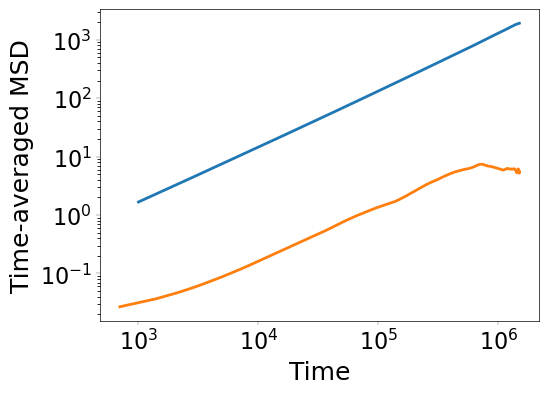

In [44]:
fig, ax = plt.subplots()
ax.plot(df['Time'].values[1:], df['MSD'].values[1:], label='f=3')
ax.plot(df2['Time'].values[1:], df2['MSD'].values[1:], label='f=4')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Time-averaged MSD')

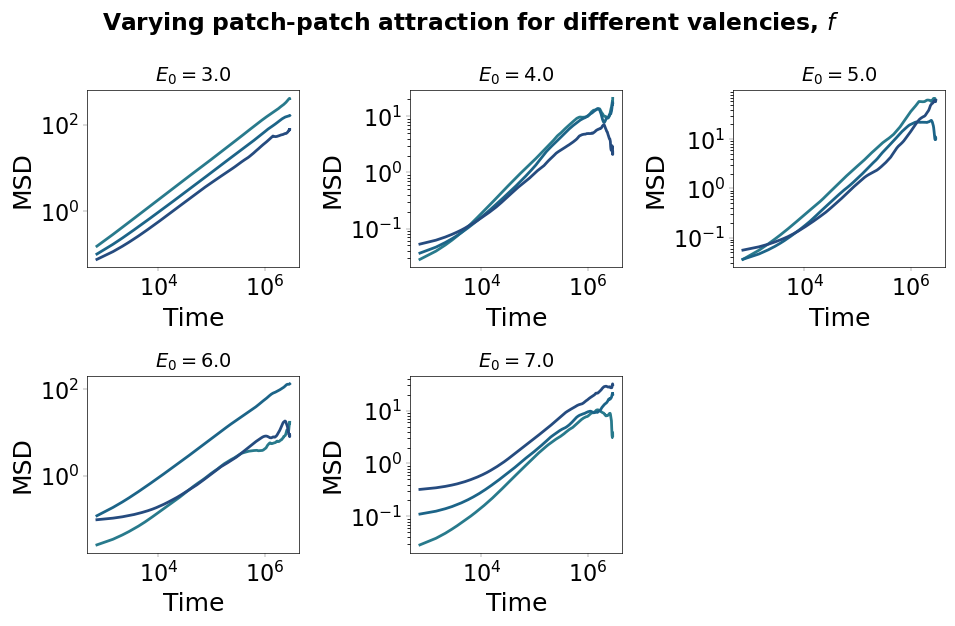

In [33]:
num_rows = 2
num_cols = 3
fig = plt.figure(figsize=(3*1.1*num_cols, 2 + 2*1.1*num_rows))
gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

i=0
E0s = [3.0, 4.0, 5.0, 6.0, 7.0]
for E0, mat in path_df.groupby('E0'):
    mat = mat[mat["r"] == 0.5]
    if E0 in E0s:
        df = mat.sort_values('f')
        valencies = df['f'].values
        colors = sns.color_palette("crest", len(valencies))
        paths = df['path'].values

        #plot MSD
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        for j, path in enumerate(paths):
            if valencies[j] < 4:
                msd_df = pd.read_csv(path/'time_ave_msd_every_other_10.csv')
            else:
                msd_df = pd.read_csv(path/'time_ave_msd_every_other_10_start7142.csv')
                ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        color=colors[j], label=f"f={valencies[j]}")
        ax.set_xlabel('Time')
        ax.set_ylabel('MSD')
        ax.set_xscale('log')
        ax.set_yscale('log')
        #if i == 0:
        #    ax.legend()
        ax.set_title(f"$E_0={E0}$", fontsize=14)
        i += 1

fig.suptitle(r"Varying patch-patch attraction for different valencies, $f$", fontweight='bold')
fig.tight_layout()
plt.savefig('plots/time_averaged_MSD_varyingE0_f1-6_long_times.pdf')

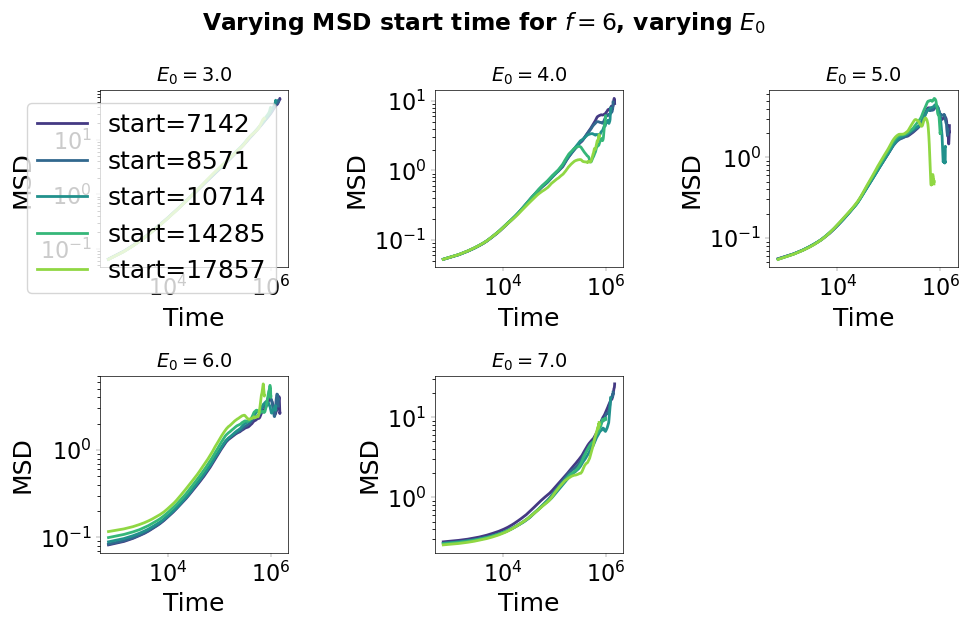

In [36]:
num_rows = 2
num_cols = 3
fig = plt.figure(figsize=(3*1.1*num_cols, 2 + 2*1.1*num_rows))
gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)

i=0
E0s = [3.0, 4.0, 5.0, 6.0, 7.0]
timestep = 70

for E0 in E0s:
    path = simdir / f'N1000_f6_E0{E0}_v0.3'
    start_files = np.array([file for file in path.glob('time_ave_msd*start*.csv')])
    start_times = np.array([int(str(file.name).split('_')[-1].split('.')[0][5:]) for file in start_files])
    start_files = start_files[np.argsort(start_times)]
    start_times = start_times[np.argsort(start_times)]

    colors = sns.color_palette("viridis", len(start_times))

    #plot MSD
    x = i // num_cols
    y = i % num_cols
    ax = fig.add_subplot(gs[x, y])
    for j, file in enumerate(start_files):
        msd_df = pd.read_csv(file)
        ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                    color=colors[j], label=f"start={start_times[j]}")
    ax.set_xlabel('Time')
    ax.set_ylabel('MSD')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i == 0:
        ax.legend()
    ax.set_title(f"$E_0={E0}$", fontsize=14)
    i += 1

fig.suptitle(r"Varying MSD start time for $f=6$, varying $E_0$", fontweight='bold')
fig.tight_layout()
plt.savefig('plots/time_averaged_MSD_varyingE0_f6_varying_starts.pdf')

In [28]:
path = simdir / f'N1000_f6_E03.0_v0.3'
timestep = 70
start_files = np.array([file for file in path.glob('time_ave_msd*start*.csv')])
start_times = np.array([int(str(file.name).split('_')[-1].split('.')[0][5:]) for file in start_files])
start_files[np.argsort(start_times)]

array([PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start7142.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start8571.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start10714.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start14285.csv'),
       PosixPath('/net/levsha/share/deepti/simulations/protein_mobility/N1000_f6_E03.0_v0.3/time_ave_msd_every_other_10_start17857.csv')],
      dtype=object)

In [25]:
list(np.argsort(start_times))

[0, 4, 3, 1, 2]

In [27]:
start_times[[0,4,3,1,2]]

TypeError: list indices must be integers or slices, not list

## Quantify diffusion coefficient 

In [24]:
path_df

,N,f,E0,v,r,path
0,1000,5,0.1,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
1,1000,2,2.5,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
2,1000,3,7.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
3,1000,5,6.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
4,1000,1,3.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
...,...,...,...,...,...,...
71,1000,3,4.0,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
72,1000,2,0.3,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...
73,1000,1,3.0,0.3,0.25,/net/levsha/share/deepti/simulations/protein_m...
74,1000,2,1.5,0.3,0.50,/net/levsha/share/deepti/simulations/protein_m...


In [26]:
Dapps = []
alphas = []
for path in path_df['path'].values:
    if (path/'sphere_msds_start5000_every_other_10.csv').is_file():
        msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
        result = sp.stats.linregress(msd_df['Time'].values - msd_df['Time'].values[0], msd_df['MSD'].values)
        print(f"Fit from linear space: {result.slope}t + {result.intercept}")
        log_result = sp.stats.linregress(np.log10(msd_df['Time'].values[1:] - msd_df['Time'].values[0]), np.log10(msd_df['MSD'].values[1:]))
        print(f"Fit from log space: {10**log_result.intercept}, alpha={log_result.slope}")
        Dapps.append(result.slope)
    else:
        Dapps.append(0.0)
path_df['Dapp'] = Dapps

Fit from linear space: 0.2794239554001905t + -7.015012125587873
Fit from log space: 0.25431077942821373, alpha=1.0096564309012528
Fit from linear space: 0.7030199027500083t + -33.38070749464532
Fit from log space: 0.7098311492235028, alpha=0.9980397299717595
Fit from linear space: 0.0007166653853770028t + 3.7857802366266977
Fit from log space: 0.014581408665224088, alpha=0.7170548650121606
Fit from linear space: 0.006667469625628553t + 10.256476840675447
Fit from log space: 0.0033399082724157895, alpha=1.0874316244246924
Fit from linear space: 1.2554549848026995t + 113.46440702109976
Fit from log space: 1.3197028219251177, alpha=0.9960362182906705
Fit from linear space: 1.3320651895273712t + -59.81653091964654
Fit from log space: 1.405552871053128, alpha=0.9932461901566116
Fit from linear space: 0.5974017866386675t + -25.780572532145925
Fit from log space: 0.5841175528718225, alpha=1.001762837921985
Fit from linear space: 0.252982281028939t + -40.58132201736453
Fit from log space: 0.20

Fit from linear space: 0.5152268635947157t + -9.636877640393777
Fit from log space: 0.49466114804696787, alpha=1.0041384719940785
Fit from linear space: 0.00056851966821764t + 5.112870657644327
Fit from log space: 0.004722863300950779, alpha=0.840947213647689
Fit from linear space: 0.1292331137939644t + 5.726288401436932
Fit from log space: 0.1457819181673188, alpha=0.9873517819085935
Fit from linear space: 0.7707642151709301t + 74.35197706227882
Fit from log space: 0.7522319860521108, alpha=1.0043594147353516
Fit from linear space: 0.7623058468475121t + -18.6364161481024
Fit from log space: 0.6945261902758096, alpha=1.0099231379049785


In [10]:
msd_df = pd.read_csv('results/N1000_f3_E00.5_v0.3/sphere_msds_start5000_every_other_10.csv')
msd_df

,Time,MSD
0,0,0.000000
1,10,5.607067
2,20,11.797545
3,30,17.395723
4,40,22.691092
...,...,...
1495,14950,8633.661000
1496,14960,8643.843000
1497,14970,8646.640000
1498,14980,8644.898000


In [22]:
#flory huggins spinodal prediction: chi has to be larger than this value

def chi(phi, f):
    return (1 + (f - 1)*phi)/(2*f*phi*(1 - phi))

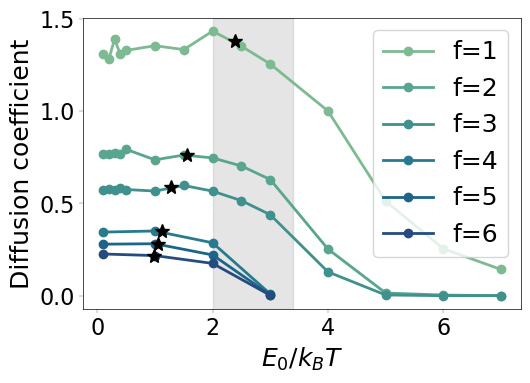

In [37]:
from scipy.interpolate import CubicSpline

fig, ax = plt.subplots()
colors = sns.color_palette("crest", 6)
for f, mat in path_df.groupby('f'):
    mat = mat[mat["r"]==0.5]
    df = mat.sort_values('E0')
    if f >= 4:
        ax.plot(df['E0'].values[0:4], df['Dapp'].values[0:4], '-o', label=f"f={f}", color=colors[f-1])
        cs = CubicSpline(df['E0'].values[0:4], df['Dapp'].values[0:4])
    else:
        ax.plot(df['E0'], df['Dapp'], '-o', label=f"f={f}", color=colors[f-1])
        cs = CubicSpline(df['E0'], df['Dapp'])
    #flory huggins prediction for spinodal -- chi(0.3)
    chi_critical = chi(0.3, f)
    ax.plot(chi_critical, cs(chi_critical), '*', color="k", markersize=10)

ax.axvspan(2, 2 + np.log(4), color='grey', alpha=0.2)
ax.legend()
#ax.set_yscale('log')
ax.set_xlabel('$E_0 / k_B T$')
ax.set_ylabel('Diffusion coefficient')
fig.tight_layout()
plt.savefig('plots/diffusion_coefficient_vs_E0_f1-6_flory_huggins_shade.pdf')

## Plot patch-patch attraction potential

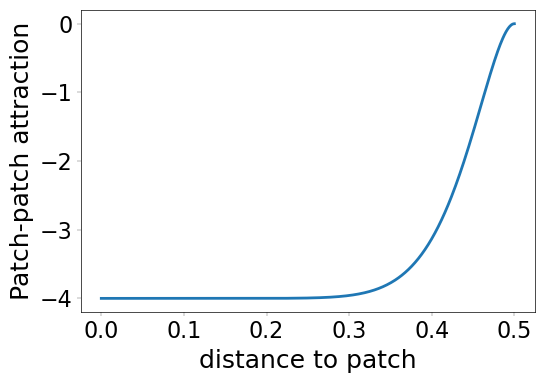

In [46]:
def f(x):
    term1 = (x/0.5)* np.sqrt(6/7)
    term2 = 1 + (term1**12) * (term1**2 - 1) * (823543/46656)
    return -4 * term2

x = np.linspace(0,0.5,500)
fig, ax = plt.subplots()
plt.plot(x,f(x))
plt.xlabel("distance to patch")
plt.ylabel("Patch-patch attraction")
fig.tight_layout()
plt.savefig('plots/patch_attraction_potential.pdf')

In [21]:
#flory huggins spinodal prediction: chi has to be larger than this value

def chi(phi, f):
    return (1 + (f - 1)*phi)/(2*f*phi*(1 - phi))

print(chi(0.3, 1))
print(chi(0.3, 2))
print(chi(0.3, 3))
print(chi(0.3, 4))  
print(chi(0.3, 5))
print(chi(0.3, 6))

2.380952380952381
1.5476190476190477
1.2698412698412702
1.130952380952381
1.047619047619048
0.9920634920634922


## Clustering on distance matrices

In [38]:
from sklearn.cluster import DBSCAN

In [34]:
ln(4)

NameError: name 'ln' is not defined